## 前情函数

In [1]:
import tensorflow as tf
import numpy as np


tf.__version__

'2.0.0'

### map 函数介绍
map(  
&ensp;&ensp;&ensp;&ensp;map_func, num_parallel_calls=None  
)  
**map函数的目的是对每一个数据进行 map_func 函数变化，例如 map_func 函数的目的是加一操作，那么 map 函数将让所有值都加一**
map 函数具有两个输入，一个是 map_func，这是要求输入一个数据处理的函数，另一个是 num_parallel_calls，是并行处理时需求的参数，一般用 None 或者使用 tf.data.experimental.AUTOTUNE 来让计算机自适应并行计算

In [2]:
a = tf.data.Dataset.range(1, 6)
for data in a:
    print(data.numpy(), end=' ')
print('\n*********')

a_map = a.map(map_func=lambda x: x + 1)
for data in a_map:
    print(data.numpy(), end=' ')

1 2 3 4 5 
*********
2 3 4 5 6 

In [3]:
def func(input_data):
    return 2 * input_data

a = tf.data.Dataset.range(1, 6)
for data in a:
    print(data.numpy(), end=' ')
print('\n*********')

a_map = a.map(func)
for data in a_map:
    print(data.numpy(), end=' ')

1 2 3 4 5 
*********
2 4 6 8 10 

### tf.data.Dataset.from_tensor_slices
主要针对小批量数据集

In [4]:
X = np.array([520, 502, 521, 555])
Y = np.array([1, 2, 3, 4])

dataset = tf.data.Dataset.from_tensor_slices((X, Y))

for x, y in dataset:
    print(x.numpy(), y.numpy())

del X; del Y

520 1
502 2
521 3
555 4


Dataset 利用 iter() 显式的创建一个 Python 迭代器并使用 next() 方法获取下一个元素

In [5]:
X = tf.constant([520, 502, 521, 555])
Y = tf.constant([1, 2, 3, 4])

dataset = tf.data.Dataset.from_tensor_slices((X, Y))

data_it = iter(dataset)

for i in range(len(X)):
    x, y = data_it.next()
    print(x.numpy(), y.numpy())

del X; del Y

520 1
502 2
521 3
555 4


## 正式开始

### 模块导入

In [6]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

tf.keras.__version__

'2.2.4-tf'

### 文件获取函数
获取文件名并对文件名打上相应的标签

In [7]:
def read_image_filenames(data_dir):
    filenames = []
    labels = []
    for file in os.listdir(data_dir):
        filenames.append(os.path.join(data_dir, file))
        name = file.split('.')[0]
        if name == 'cat':
            label = 0
        else:
            label = 1
        labels.append(label)
    
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    return filenames, labels

### 图像解码函数
将图像变换为矩阵，并 resize 与 归一化

In [8]:
def decode_image_and_resize(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    
    image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0
    
    return image_resized, label

### 展示读取文件与可视化

In [9]:
train_data_dir = './data/train1/'
filenames, labels = read_image_filenames(train_data_dir)
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

In [10]:
demo_dataset = dataset.take(5)

for file, label in demo_dataset:
    print('filename:', file.numpy(), (25-len(file.numpy())) * ' ', 'label:', label.numpy())

del demo_dataset

filename: b'./data/train1/cat.0.jpg'    label: 0
filename: b'./data/train1/cat.1.jpg'    label: 0
filename: b'./data/train1/cat.10.jpg'   label: 0
filename: b'./data/train1/cat.100.jpg'  label: 0
filename: b'./data/train1/cat.1000.jpg'  label: 0


In [11]:
dataset = dataset.map(map_func=decode_image_and_resize,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

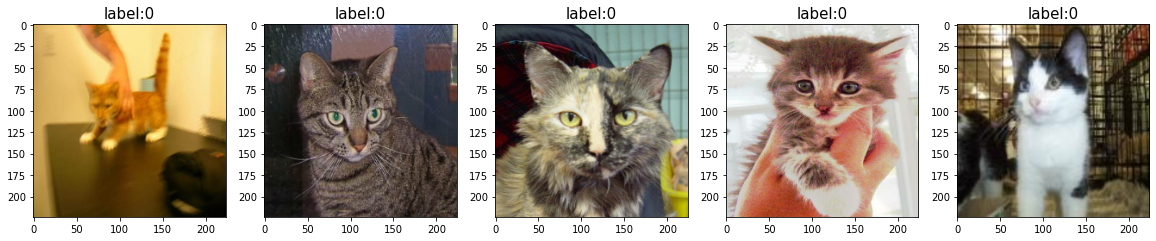

In [12]:
demo_dataset = dataset.take(5)
fig = plt.gcf()
fig.set_size_inches(20, 4)

i = 0
for file, label in demo_dataset:
    i += 1
    ax = plt.subplot(1, 5, i)
    ax.imshow(file, cmap='binary')
    title = 'label:' + str(label.numpy())
    ax.set_title(title, fontsize=15)
plt.show()

del demo_dataset

### 函数重构
将前面的操作封装成一个函数，命名为 prepare_dataset

In [143]:
def prepare_dataset(data_dir='data/train1/', buffer_size=10000, batch_size=16):
    filenames, labels = read_image_filenames(data_dir)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(map_func=decode_image_and_resize,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [144]:
dataset_train = prepare_dataset()

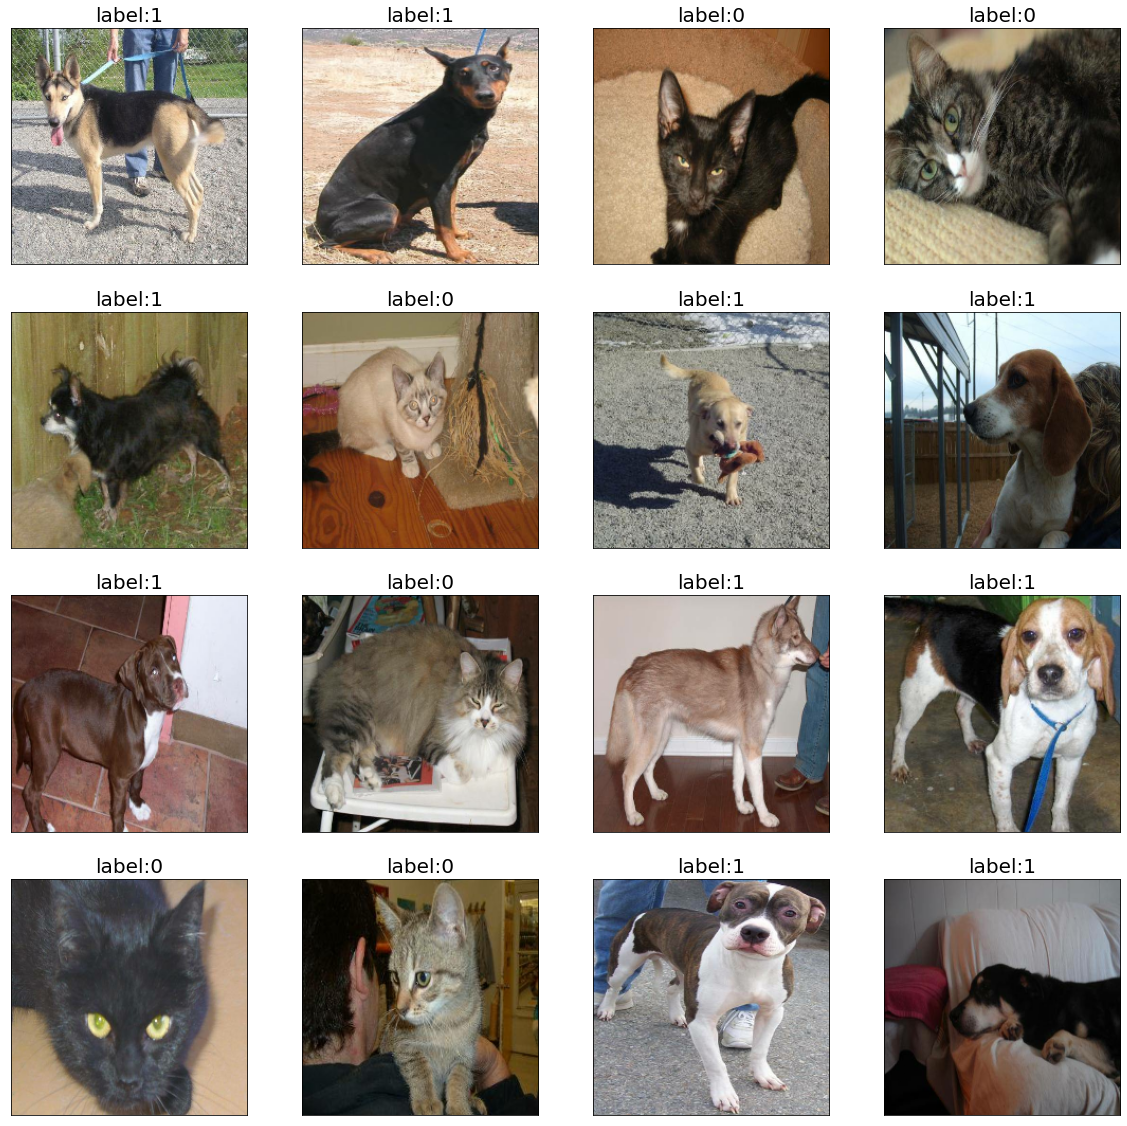

In [145]:
demo_dataset = dataset_train.take(1)
fig = plt.gcf()
fig.set_size_inches(20, 20)


for file, label in demo_dataset:
    i = 0
    for i in range(len(label)):
        ax = plt.subplot(4, 4, i+1)
        ax.imshow(file[i], cmap='binary')
        title = 'label:' + str(label.numpy()[i])
        ax.set_title(title, fontsize=20)
        ax.set_xticks([])
        ax.set_yticks([])
        i += 1

plt.show()

### 建立模型

In [16]:
def vgg16_model(input_shape=(224, 224, 3)):
    vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                             weights='imagenet', 
                                             input_shape=input_shape)
    for layer in vgg16.layers:
        layer.trainable=False
    
    last = vgg16.output
    
    x = tf.keras.layers.Flatten()(last)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=vgg16.input, outputs=x)
    model.summary()
    
    return model

### 摘要输入
通过摘要可以发现，我们只需要训练 300w 参数

In [17]:
model = vgg16_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 开始训练

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
train_epochs = 5

In [20]:
train_history = model.fit(dataset_train, epochs=train_epochs, verbose=1)

Epoch 1/5
625/625 [==============================] - 200s 321ms/step - loss: 0.4188 - accuracy: 0.8132
Epoch 2/5
625/625 [==============================] - 188s 301ms/step - loss: 0.2386 - accuracy: 0.9023
Epoch 3/5
625/625 [==============================] - 183s 293ms/step - loss: 0.1999 - accuracy: 0.9196
Epoch 4/5
625/625 [==============================] - 182s 291ms/step - loss: 0.1626 - accuracy: 0.9371
Epoch 5/5
625/625 [==============================] - 181s 290ms/step - loss: 0.1365 - accuracy: 0.9449


### 模型存储
需要安装 pyyaml，在终端输入 `pip install pyyaml`，或在 jupyter 输入 `!pip install pyyaml`

In [28]:
if not os.path.exists('./yaml_models'):
    os.mkdir('./yaml_models')

yaml_string = model.to_yaml()

with open('./yaml_models/cat_vs_dog.yaml', 'w') as model_file:
    model_file.write(yaml_string)

model.save_weights('./yaml_models/cat_vs_dog.h5')

### 应用模型与可视化

In [29]:
with open('./yaml_models/cat_vs_dog.yaml') as yamlfile:
    loaded_model_yaml = yamlfile.read()

model = tf.keras.models.model_from_yaml(loaded_model_yaml)
model.load_weights('./yaml_models/cat_vs_dog.h5')

随机选取 num 张进行预测

In [108]:
from tensorflow.keras.preprocessing import image

def read_image_files(test_dir='./data/test1', num=16, image_size=(224, 224)):
    image_name_list = []
    image_list = []
    files = os.listdir(test_dir)
    for i in range(num):
        choose = np.random.randint(len(files))
        image_file = os.path.join(test_dir, files[choose])
        files.remove(files[choose])
        img = image.load_img(image_file, target_size=image_size)
        img_array = image.img_to_array(img)
        image_list.append(img_array)
        image_name_list.append(files[choose])
    test_data = np.array(image_list)
    test_data /= 255.0
    print('INFO:%d images have been loaded!' % num)
    return test_data, image_name_list, image_list, num

In [119]:
import math

def predict_show():
    test_data, image_name_list, image_list, num = read_image_files()
    preds = model.predict(test_data)
    result = np.argmax(preds, 1)

    fig = plt.gcf()
    fig.set_size_inches(20, 20)

    i = 0
    for probs in result:
        ax = plt.subplot(math.ceil(num / 4), 4, i+1)
        ax.imshow(image_list[i].astype('uint8'), cmap='binary')
        if probs == 0:
            label = 'cat→'+ image_name_list[i] + ' probs:' + str(preds[i][0])
        else:
            label = 'dog→' + image_name_list[i] + ' probs:' +str(preds[i][1])
        i += 1
        ax.set_title(label, fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

INFO:16 images have been loaded!


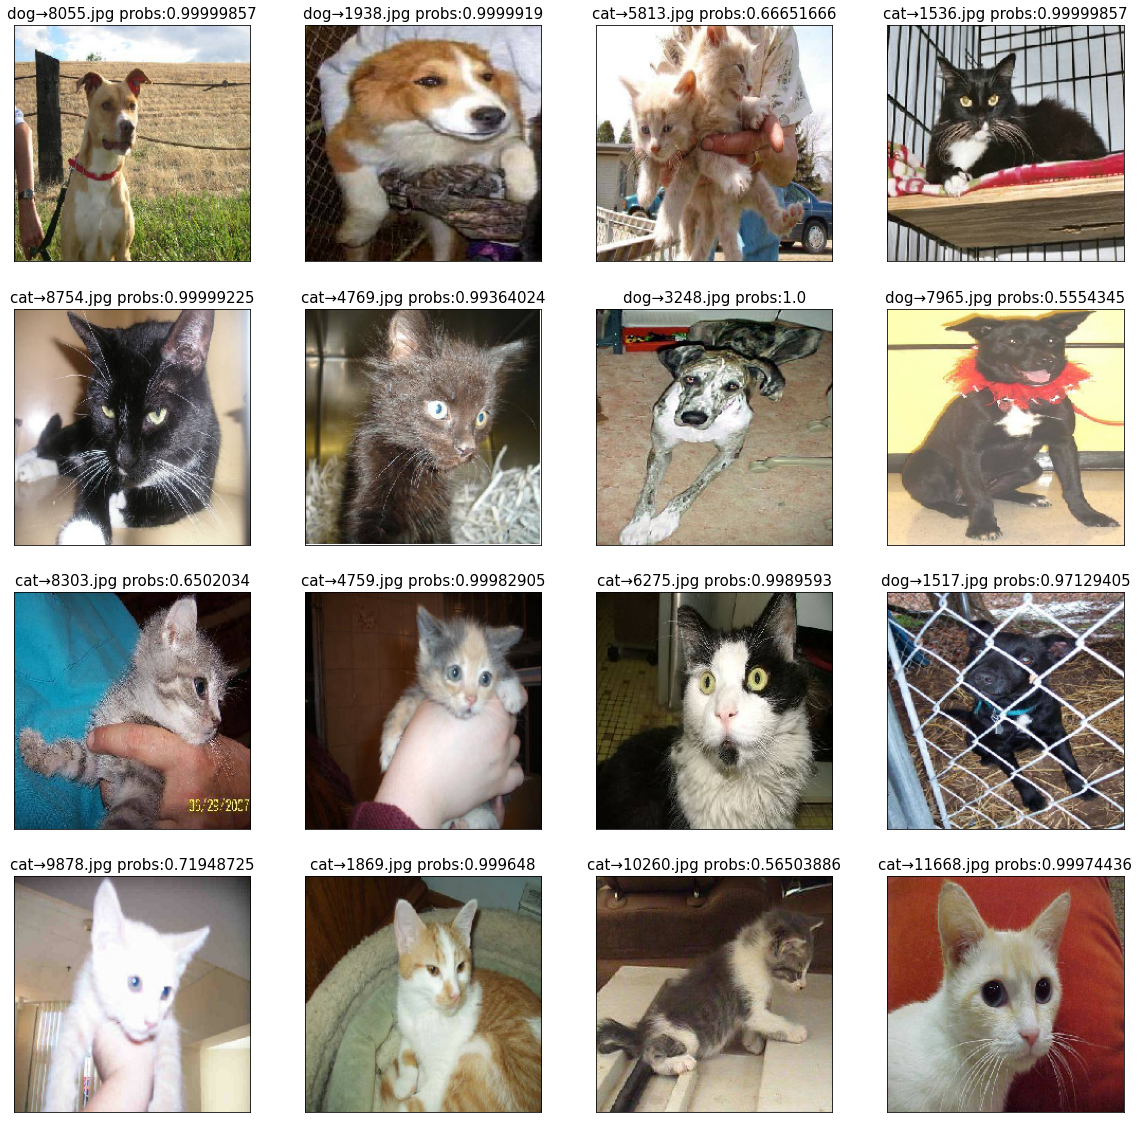

In [120]:
predict_show()

## TFRecord 制作

### 定义文件与标签获取函数

In [126]:
def get_image_filenames(data_dir):
    filenames = []
    labels = []
    for file in os.listdir(data_dir):
        filenames.append(os.path.join(data_dir, file))
        name = file.split('.')[0]
        if name == 'cat':
            label = 0
        else:
            label = 1
        labels.append(label)

    return filenames, labels

### 定义 TFRecord 写入函数

In [131]:
def write_TFRecord_file(filenames, labels, tfrecord_file):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename, label in zip(filenames, labels):
            image = open(filename, 'rb').read()
            feature={
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            
            writer.write(example.SerializeToString())

### 开始写入

In [133]:
tfrecord_file = 'data/train1.tfrecords'

if not os.path.isfile(tfrecord_file):
    filenames, labels = get_image_filenames('data/train1')
    write_TFRecord_file(filenames, labels, tfrecord_file)
    print('INFO: TFRecord file has been wrote to', tfrecord_file, '.')
else:
    print('INFO: TFRecord file already exists.')

INFO: TFRecord file already exists.


### TFRecord 解码与可视化

### 定义描述字典

In [134]:
features_description={
   'label': tf.io.FixedLenFeature([], tf.int64),
   'image' : tf.io.FixedLenFeature([], tf.string),
}

def parse_example(example_string):
    features_dict = tf.io.parse_single_example(example_string, features_description)
    features_dict['image'] = tf.io.decode_jpeg(features_dict['image'])
    features_dict['image'] = tf.image.resize(features_dict['image'], [224, 224]) / 255.0
    
    return features_dict['image'], features_dict['label']

### 定义解码读取函数

In [135]:
def read_TFRecord_file(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = raw_dataset.map(parse_example)
    
    return dataset

### 解码与可视化

In [136]:
buffer_size = 10000

batch_size = 16

dataset_train = read_TFRecord_file(tfrecord_file).shuffle(buffer_size).batch(batch_size)

In [137]:
dataset_train

<BatchDataset shapes: ((None, 224, 224, None), (None,)), types: (tf.float32, tf.int64)>

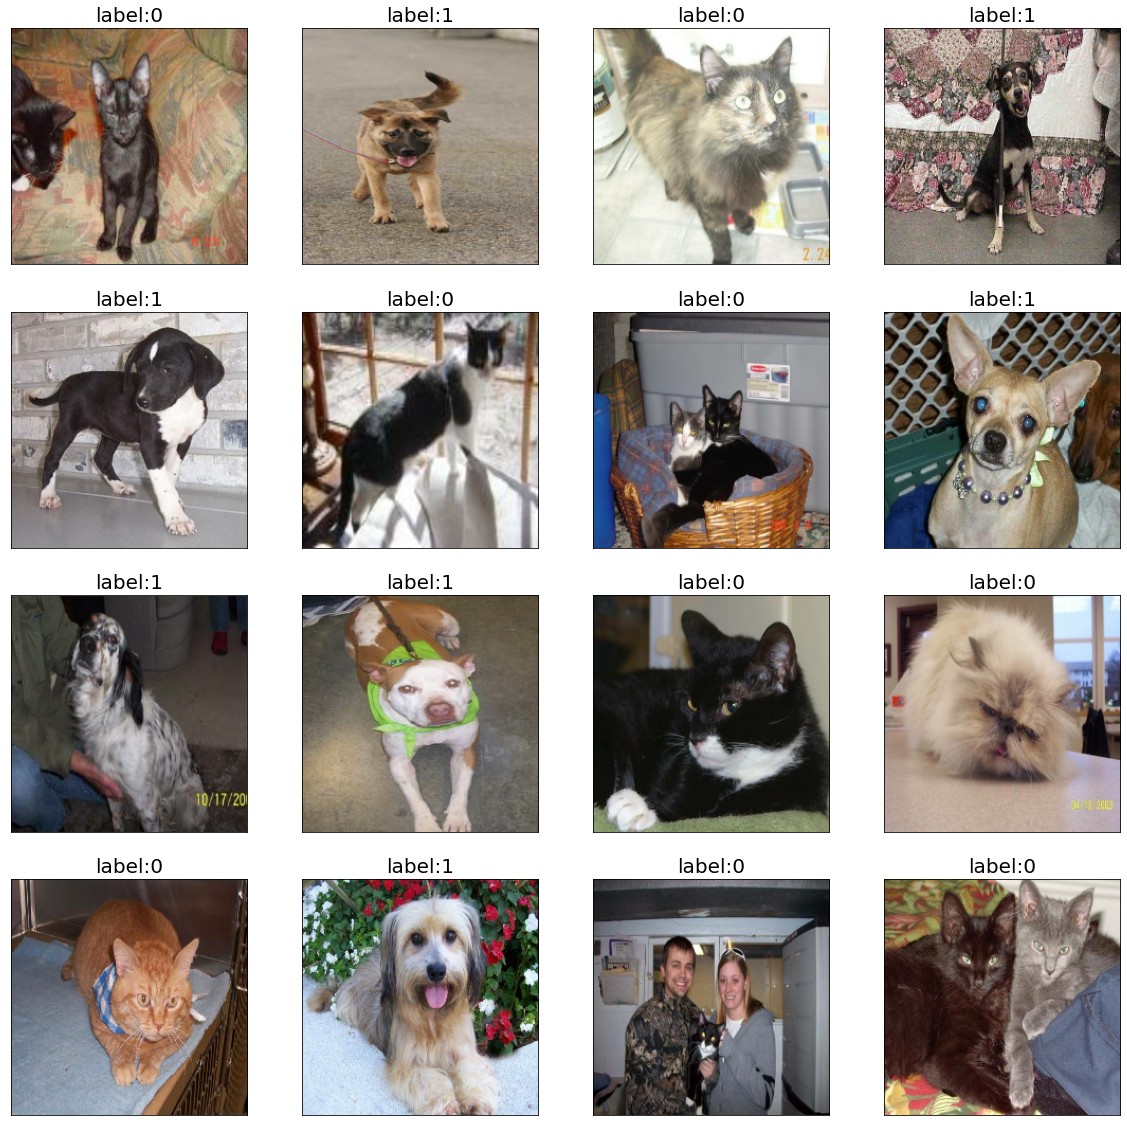

In [142]:
demo_dataset = dataset_train.take(1)
fig = plt.gcf()
fig.set_size_inches(20, 20)


for file, label in demo_dataset:
    i = 0
    for i in range(len(label)):
        ax = plt.subplot(4, 4, i+1)
        ax.imshow(file[i], cmap='binary')
        title = 'label:' + str(label.numpy()[i])
        ax.set_title(title, fontsize=20)
        ax.set_xticks([])
        ax.set_yticks([])
        i += 1

plt.show()

### 陷入无尽的循环吧
殊途同归，最终利用 TFRecord 得到最初 dataset，照着前面的葫芦就可以开始训练了，这里省略XX字